# PSM Segmentation from Channel 1 Only - Baseline Experiment

## Overview

This notebook is a **baseline experiment** testing whether PSM can be segmented using only Channel 1 (nuclei marker, H2B-Cerulean). It uses Channel 3 masks as pseudo-ground-truth for training and evaluation.

## Purpose

This experiment was conducted to understand the contribution of each channel individually before combining them. **Result**: Channel 1 alone achieves only Dice ~0.42, significantly worse than the combined CH1+CH2 approach (Dice ~0.70).

## Why This Fails

Channel 1 shows nuclei throughout the entire embryo, not specifically in PSM. The model tends to segment all visible tissue rather than just the PSM region.

## Key Finding

Single-channel approaches are insufficient for marker-free PSM segmentation. The combination of both channels with position features is required.

## How to Use

This notebook is provided for reproducibility. To run:
1. Ensure Channel 3 masks exist in `mask_santi/`
2. Run all cells sequentially
3. Compare results with `PSM_From_CH1_CH2_Improved.ipynb`


In [1]:
# Install missing packages if needed
import subprocess
import sys

try:
    import sklearn
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn", "--quiet"])
    print("Installed scikit-learn")

try:
    import tifffile
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tifffile", "--quiet"])
    print("Installed tifffile")

print("Dependencies OK!")

Dependencies OK!


In [2]:
# %% CELL 1: SETUP & LIBRARIES
import os
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tifffile import imread, imwrite

from scipy import ndimage as ndi
from scipy.ndimage import gaussian_filter

from skimage import filters, morphology, measure, transform

from sklearn.ensemble import RandomForestClassifier
import joblib

np.random.seed(42)
print("Imports loaded.")


Imports loaded.


In [3]:
# %% CELL 2: CONFIGURATION
# =============================================================================
# USER CONFIGURATION (CHANGE THESE)
# =============================================================================
RAW_CHANNEL = 1                                 # Input channel to predict PSM
MASK_FOLDER = "mask_santi"                      # Folder with CH3 masks for training

# =============================================================================
# AUTO-DETECT DATA LOCATION
# =============================================================================
current_dir = Path(".")
parent_dir = Path("..")

if (current_dir / MASK_FOLDER).exists():
    BASE_DIR = current_dir
elif (parent_dir / MASK_FOLDER).exists():
    BASE_DIR = parent_dir
else:
    BASE_DIR = parent_dir
    print(f"[WARNING] Could not find '{MASK_FOLDER}'. Set BASE_DIR manually.")

RAW_DIR = BASE_DIR
GT_MASK_DIR = BASE_DIR / MASK_FOLDER

# Output folder for this model
OUTPUT_DIR = BASE_DIR / f"psm_from_ch{RAW_CHANNEL}"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = OUTPUT_DIR / f"rf_model_psm_from_ch{RAW_CHANNEL}.joblib"
FEATURE_STATS_PATH = OUTPUT_DIR / "feature_stats.joblib"
PROGRESS_PATH = OUTPUT_DIR / "progress.json"
RESULTS_PATH = OUTPUT_DIR / "results.csv"
VIZ_DIR = OUTPUT_DIR / "visualizations"
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Same training frames used in the Channel 3 pipeline
TRAINING_FRAMES = [1, 30, 70, 120, 140, 180, 200]

# Quick test mode (default): run only on 5 frames
TEST_MODE = True
TEST_FRAMES = [30, 60, 120, 150, 200]

# Downsampling for speed (same as Channel 3 pipeline)
SCALE_FACTOR = 0.25

# Slices used for training sampling (center +/- offset after downsampling)
SLICE_OFFSET = 8

# Define safe zones around the GT mask to avoid noisy boundaries during training
SAFE_EROSION_RADIUS = 2
SAFE_DILATION_RADIUS = 2

# 3D post-processing (same style as Channel 3 pipeline)
CLOSING_RADIUS_3D = 8
SMOOTH_SIGMA = 2.0

# 2D evaluation slice (fast overlap metric for quick iteration)
EVAL_Z_SLICE = 188

print("Configuration:")
print(f"  RAW_CHANNEL       : {RAW_CHANNEL}")
print(f"  TEST_MODE         : {TEST_MODE}")
print(f"  TEST_FRAMES       : {TEST_FRAMES}")
print(f"  TRAINING_FRAMES   : {TRAINING_FRAMES}")
print(f"  GT_MASK_DIR       : {GT_MASK_DIR}")
print(f"  OUTPUT_DIR        : {OUTPUT_DIR}")


Configuration:
  RAW_CHANNEL       : 1
  TEST_MODE         : True
  TEST_FRAMES       : [30, 60, 120, 150, 200]
  TRAINING_FRAMES   : [1, 30, 70, 120, 140, 180, 200]
  GT_MASK_DIR       : ../mask_santi
  OUTPUT_DIR        : ../psm_from_ch1


In [5]:
# %% CELL 3: FEATURE ENGINEERING
# We reuse the same 5 multi-scale features as the Channel 3 pipeline:
# 1) Raw intensity
# 2) Gaussian sigma=1.5 (fine texture)
# 3) Gaussian sigma=3.5 (shape)
# 4) Gaussian sigma=8.0 (low-frequency context)
# 5) Sobel edges

def get_multiscale_features(image_2d: np.ndarray):
    """Extract 5 multi-scale features for each pixel in a 2D slice."""
    image_2d = image_2d.astype(np.float32, copy=False)

    feats = []
    names = []

    feats.append(image_2d.flatten())
    names.append("Intensity (Raw)")

    feats.append(filters.gaussian(image_2d, sigma=1.5).flatten())
    names.append("Texture (Sigma 1.5)")

    feats.append(filters.gaussian(image_2d, sigma=3.5).flatten())
    names.append("Shape (Sigma 3.5)")

    feats.append(filters.gaussian(image_2d, sigma=8.0).flatten())
    names.append("Context (Sigma 8.0)")

    feats.append(filters.sobel(image_2d).flatten())
    names.append("Edges (Sobel)")

    X = np.vstack(feats).T
    return X, names


In [5]:
# %% CELL 4: TRAINING DATA GENERATION FROM CHANNEL 3 MASKS (PSEUDO-GT)
# We build training labels from the existing 3D masks in mask_santi.
# To reduce the impact of boundary noise, we use "safe" regions:
# - Positive (PSM): eroded GT mask
# - Negative (Background): outside a dilated GT mask
# Pixels in the boundary band are ignored.

def raw_file(t: int, channel: int) -> Path:
    return RAW_DIR / f"t{t:04d}_Channel {channel}.tif"


def gt_mask_file(t: int) -> Path:
    return GT_MASK_DIR / f"mask_t{t:04d}_Channel 3.tif"


def load_raw_volume(t: int, channel: int) -> np.ndarray:
    p = raw_file(t, channel)
    if not p.exists():
        raise FileNotFoundError(f"Missing raw file: {p}")
    return imread(str(p))


def load_gt_mask_volume(t: int) -> np.ndarray:
    p = gt_mask_file(t)
    if not p.exists():
        raise FileNotFoundError(f"Missing GT mask file: {p}")
    m = imread(str(p))
    return (m > 0)


def dice_score(pred: np.ndarray, gt: np.ndarray) -> float:
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    denom = pred.sum() + gt.sum()
    return 1.0 if denom == 0 else (2.0 * inter / denom)


def iou_score(pred: np.ndarray, gt: np.ndarray) -> float:
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return 1.0 if union == 0 else (inter / union)


def generate_training_data_from_gt(raw_vol: np.ndarray, gt_vol: np.ndarray, scale: float):
    """Generate balanced training samples from a 3D volume and its GT mask."""
    # Downsample raw volume for speed (same scaling approach as Channel 3 notebook)
    small_raw = transform.rescale(
        raw_vol.astype(np.float32, copy=False),
        scale,
        preserve_range=True,
        anti_aliasing=True,
    ).astype(np.float32)

    # Resize GT mask to match downsampled raw volume
    small_gt = transform.resize(
        gt_vol.astype(np.float32),
        small_raw.shape,
        order=0,
        preserve_range=True,
        anti_aliasing=False,
    ) > 0.5

    zc = small_raw.shape[0] // 2
    z_slices = [zc, zc - SLICE_OFFSET, zc + SLICE_OFFSET]

    X_list, y_list = [], []

    for z in z_slices:
        if z < 0 or z >= small_raw.shape[0]:
            continue

        img = small_raw[z]
        msk = small_gt[z]

        # Basic sanity check on GT size
        msz = int(msk.sum())
        if msz < 50 or msz > 25000:
            continue

        safe_tissue = morphology.binary_erosion(msk, morphology.disk(SAFE_EROSION_RADIUS))
        unsafe = morphology.binary_dilation(msk, morphology.disk(SAFE_DILATION_RADIUS))
        safe_bg = ~unsafe

        labels = np.zeros(img.shape, dtype=np.uint8)
        labels[safe_tissue] = 1
        labels[safe_bg] = 2

        X, _ = get_multiscale_features(img)
        y = labels.flatten()

        idx_pos = np.where(y == 1)[0]
        idx_neg = np.where(y == 2)[0]

        n = min(len(idx_pos), len(idx_neg))
        if n == 0:
            continue

        # Balance classes to 1:1
        idx_pos = np.random.choice(idx_pos, size=n, replace=False)
        idx_neg = np.random.choice(idx_neg, size=n, replace=False)
        idx = np.concatenate([idx_pos, idx_neg])

        X_list.append(X[idx])
        y_list.append(y[idx])

    if not X_list:
        return None, None

    X_final = np.vstack(X_list)
    y_final = np.concatenate(y_list)
    return X_final, y_final


def train_model_from_masks(training_frames):
    """Train Random Forest using Channel 3 masks as pseudo-GT."""
    X_all, y_all = [], []

    for t in training_frames:
        print(f"Loading training frame t={t:04d}...")
        raw_vol = load_raw_volume(t, RAW_CHANNEL)
        gt_vol = load_gt_mask_volume(t)

        X, y = generate_training_data_from_gt(raw_vol, gt_vol, SCALE_FACTOR)
        if X is not None:
            X_all.append(X)
            y_all.append(y)
            print(f"  Added {len(y):,} labeled pixels (balanced).")
        else:
            print("  Skipped (no valid slices).")

        # Free memory
        del raw_vol, gt_vol

    if not X_all:
        raise RuntimeError("No training data could be generated. Check inputs and GT masks.")

    X_train = np.vstack(X_all)
    y_train = np.concatenate(y_all)

    print(f"Training Random Forest on {len(y_train):,} pixels...")

    clf = RandomForestClassifier(
        n_estimators=70,
        max_depth=12,
        n_jobs=-1,
        random_state=42,
    )
    clf.fit(X_train, y_train)

    _, feat_names = get_multiscale_features(np.zeros((10, 10), dtype=np.float32))
    feature_stats = (feat_names, clf.feature_importances_)

    joblib.dump(clf, MODEL_PATH)
    joblib.dump(feature_stats, FEATURE_STATS_PATH)

    print(f"Saved model to: {MODEL_PATH}")
    return clf, feature_stats


In [6]:
# %% CELL 5: PREDICTION & POST-PROCESSING

def predict_psm_3d(clf, raw_vol: np.ndarray):
    """Predict a 3D PSM mask from a raw 3D volume."""
    t0 = time.time()
    orig_shape = raw_vol.shape

    small_raw = transform.rescale(
        raw_vol.astype(np.float32, copy=False),
        SCALE_FACTOR,
        preserve_range=True,
        anti_aliasing=True,
    ).astype(np.float32)

    mask_small = np.zeros(small_raw.shape, dtype=np.uint8)

    for z in range(small_raw.shape[0]):
        X, _ = get_multiscale_features(small_raw[z])
        pred = clf.predict(X)
        mask_small[z] = (pred == 1).reshape(small_raw.shape[1], small_raw.shape[2]).astype(np.uint8)

    # 3D cleanup
    mask_small = morphology.binary_closing(mask_small > 0, morphology.ball(CLOSING_RADIUS_3D))
    mask_small = ndi.binary_fill_holes(mask_small)

    # Upsample back to original resolution
    full_mask = transform.resize(mask_small.astype(np.float32), orig_shape, order=0, preserve_range=True) > 0.5

    # Smooth boundaries
    full_mask = gaussian_filter(full_mask.astype(np.float32), sigma=SMOOTH_SIGMA) > 0.5

    # Keep largest connected component
    lbl = measure.label(full_mask)
    if lbl.max() > 0:
        sizes = np.bincount(lbl.ravel())
        sizes[0] = 0
        full_mask = (lbl == sizes.argmax())

    elapsed = time.time() - t0
    vol_px = int(full_mask.sum())
    return full_mask.astype(np.uint8), elapsed, vol_px


No saved model found. Training...
Loading training frame t=0001...
  Added 59,456 labeled pixels (balanced).
Loading training frame t=0030...
  Added 56,794 labeled pixels (balanced).
Loading training frame t=0070...
  Added 12,162 labeled pixels (balanced).
Loading training frame t=0120...
  Added 13,918 labeled pixels (balanced).
Loading training frame t=0140...
  Added 17,130 labeled pixels (balanced).
Loading training frame t=0180...
  Added 11,928 labeled pixels (balanced).
Loading training frame t=0200...
  Added 10,572 labeled pixels (balanced).
Training Random Forest on 181,960 pixels...
Saved model to: psm_from_ch1/rf_model_psm_from_ch1.joblib

[1/5] Processing t0030 (Channel 1)...


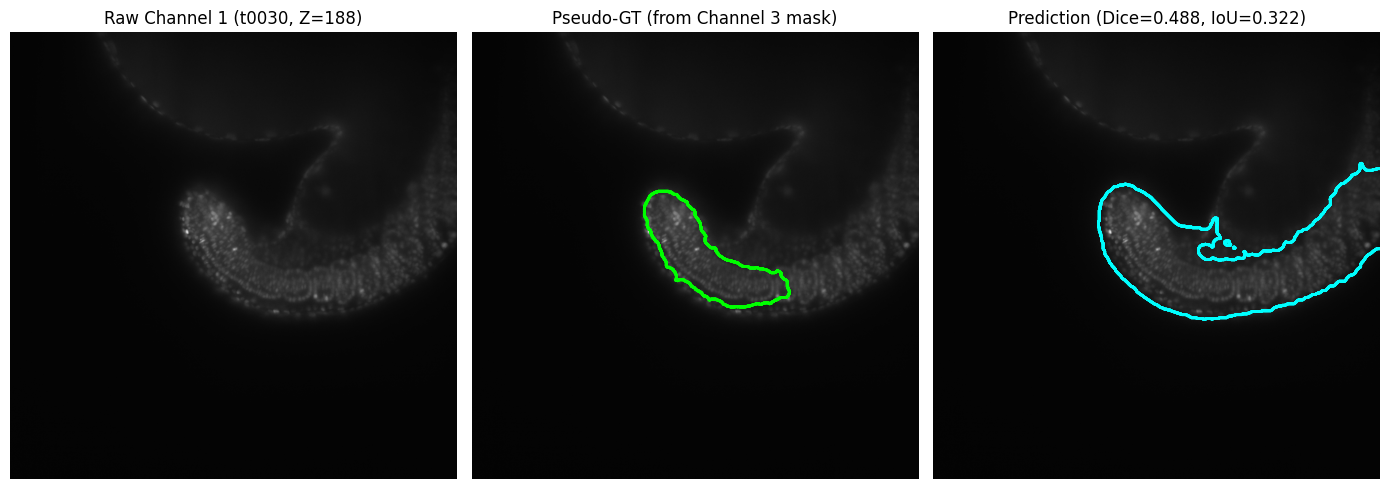

Saved mask: psm_from_ch1/mask_t0030_from_Channel_1.tif
Saved viz : psm_from_ch1/visualizations/viz_t0030_from_Channel_1.png
Dice@Z=188: 0.488 | IoU@Z=188: 0.322 | time: 215.5s

[2/5] Processing t0060 (Channel 1)...


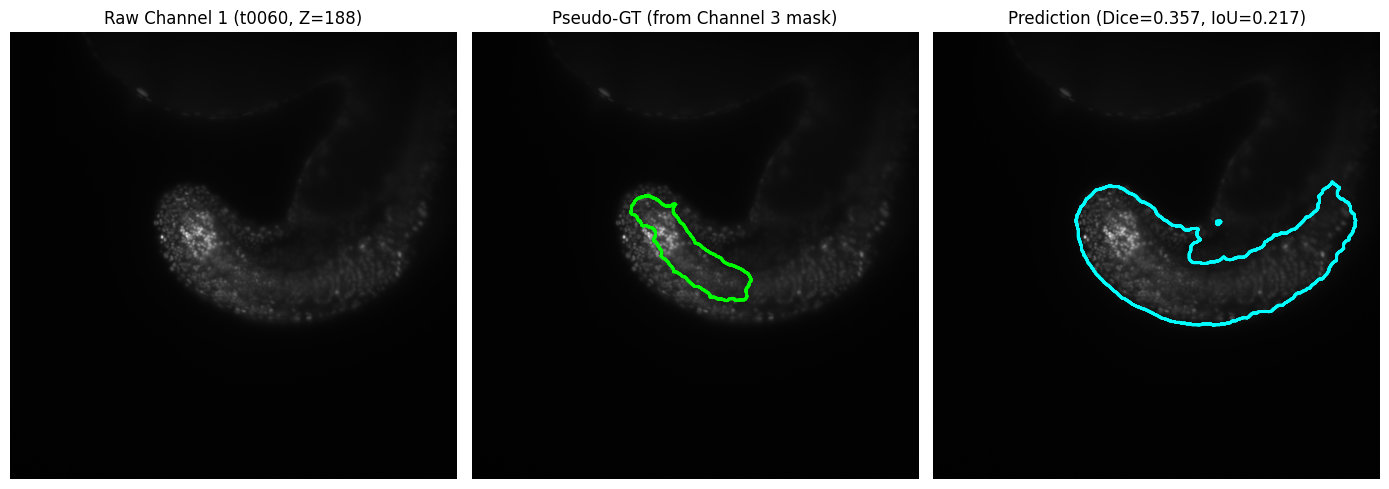

Saved mask: psm_from_ch1/mask_t0060_from_Channel_1.tif
Saved viz : psm_from_ch1/visualizations/viz_t0060_from_Channel_1.png
Dice@Z=188: 0.357 | IoU@Z=188: 0.217 | time: 217.3s

[3/5] Processing t0120 (Channel 1)...


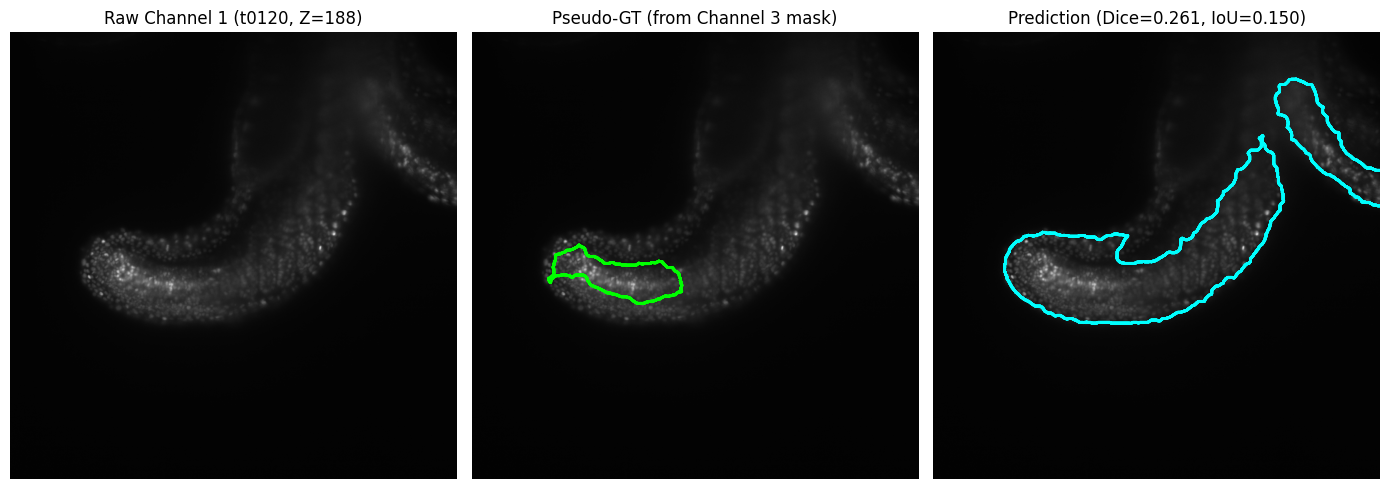

Saved mask: psm_from_ch1/mask_t0120_from_Channel_1.tif
Saved viz : psm_from_ch1/visualizations/viz_t0120_from_Channel_1.png
Dice@Z=188: 0.261 | IoU@Z=188: 0.150 | time: 216.2s

[4/5] Processing t0150 (Channel 1)...


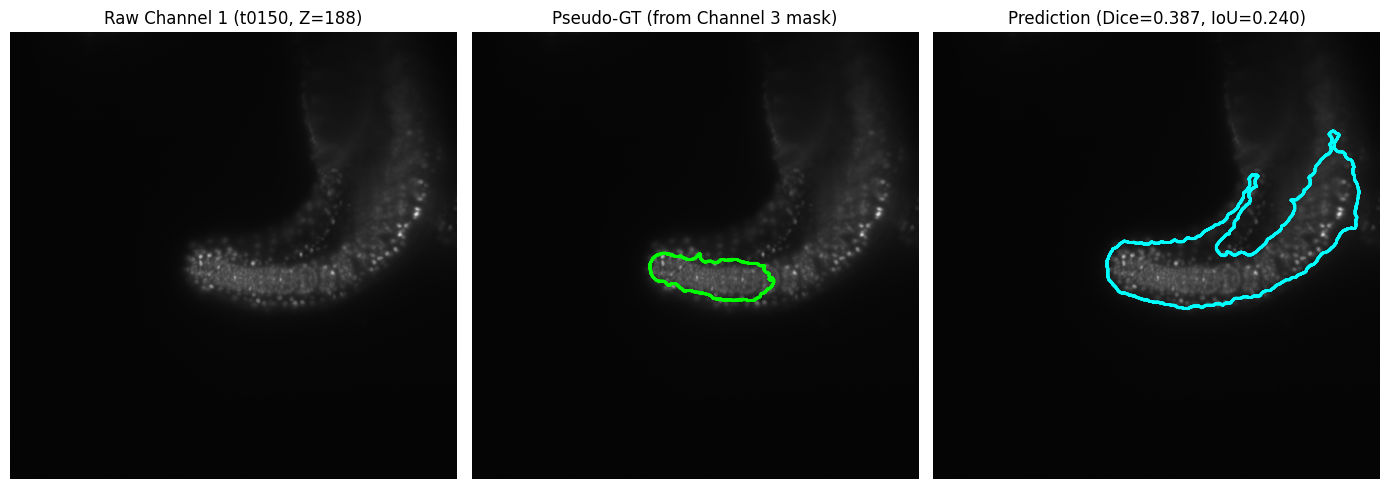

Saved mask: psm_from_ch1/mask_t0150_from_Channel_1.tif
Saved viz : psm_from_ch1/visualizations/viz_t0150_from_Channel_1.png
Dice@Z=188: 0.387 | IoU@Z=188: 0.240 | time: 207.7s

[5/5] Processing t0200 (Channel 1)...


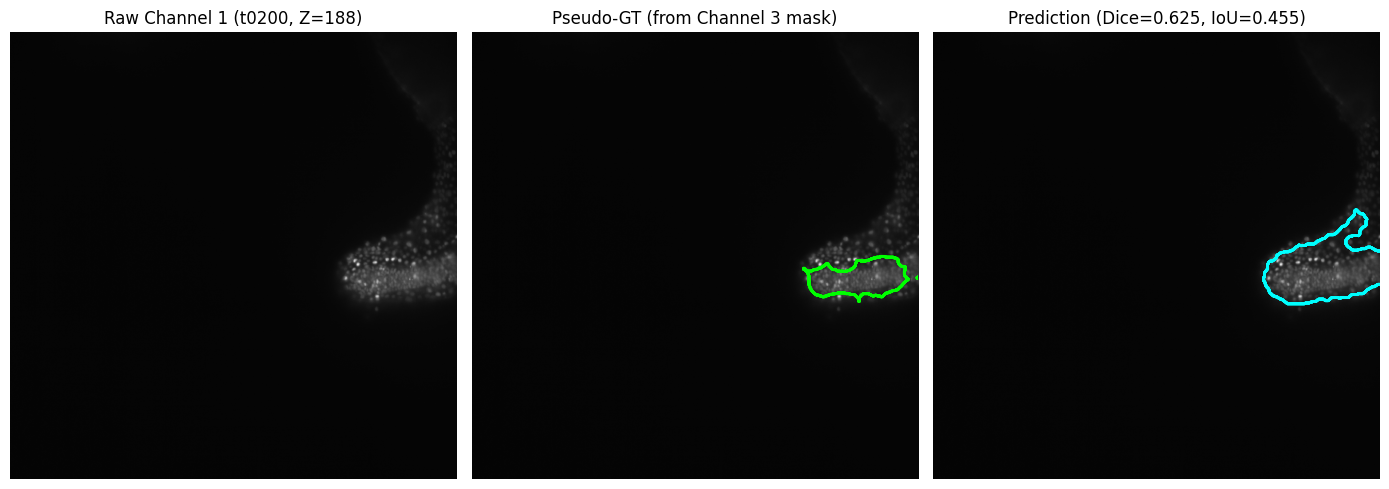

Saved mask: psm_from_ch1/mask_t0200_from_Channel_1.tif
Saved viz : psm_from_ch1/visualizations/viz_t0200_from_Channel_1.png
Dice@Z=188: 0.625 | IoU@Z=188: 0.455 | time: 199.6s

Done.
Results CSV: psm_from_ch1/results.csv
Model      : psm_from_ch1/rf_model_psm_from_ch1.joblib


In [7]:
# %% CELL 6: MAIN (TEST MODE BY DEFAULT)

# Load or train model
if MODEL_PATH.exists():
    print(f"Loading existing model: {MODEL_PATH}")
    model = joblib.load(MODEL_PATH)
    feature_stats = joblib.load(FEATURE_STATS_PATH) if FEATURE_STATS_PATH.exists() else None
else:
    print("No saved model found. Training...")
    model, feature_stats = train_model_from_masks(TRAINING_FRAMES)

# Load checkpoint
processed = []
if PROGRESS_PATH.exists():
    processed = json.loads(PROGRESS_PATH.read_text()).get("processed", [])

frames_to_run = TEST_FRAMES if TEST_MODE else list(range(1, 220))

rows = []
if RESULTS_PATH.exists():
    try:
        rows = pd.read_csv(RESULTS_PATH).to_dict("records")
    except Exception:
        rows = []

start = time.time()

for i, t in enumerate(frames_to_run):
    key = f"t{t:04d}"
    if key in processed:
        continue

    print(f"\n[{i+1}/{len(frames_to_run)}] Processing {key} (Channel {RAW_CHANNEL})...")

    try:
        raw_vol = load_raw_volume(t, RAW_CHANNEL)
        gt_vol = load_gt_mask_volume(t)

        pred_mask, elapsed, vol_px = predict_psm_3d(model, raw_vol)

        # Save predicted mask
        out_mask_path = OUTPUT_DIR / f"mask_{key}_from_Channel_{RAW_CHANNEL}.tif"
        imwrite(str(out_mask_path), pred_mask * 255)

        # Fast 2D overlap metric at Z=188
        z = EVAL_Z_SLICE
        if z >= pred_mask.shape[0]:
            z = pred_mask.shape[0] // 2

        dice = dice_score(pred_mask[z] > 0, gt_vol[z] > 0)
        iou = iou_score(pred_mask[z] > 0, gt_vol[z] > 0)

        rows.append({
            "timepoint": t,
            "channel": RAW_CHANNEL,
            "elapsed_s": float(elapsed),
            "volume_px": int(vol_px),
            "eval_z": int(z),
            "dice_z": float(dice),
            "iou_z": float(iou),
            "pred_mask": str(out_mask_path),
        })

        pd.DataFrame(rows).to_csv(RESULTS_PATH, index=False)

        processed.append(key)
        PROGRESS_PATH.write_text(json.dumps({"processed": processed}, indent=2))

        # Visualization
        fig, ax = plt.subplots(1, 3, figsize=(14, 5))
        ax[0].imshow(raw_vol[z], cmap="gray")
        ax[0].set_title(f"Raw Channel {RAW_CHANNEL} ({key}, Z={z})")
        ax[0].axis("off")

        ax[1].imshow(raw_vol[z], cmap="gray")
        ax[1].contour((gt_vol[z] > 0).astype(np.uint8), colors="lime", linewidths=2)
        ax[1].set_title("Pseudo-GT (from Channel 3 mask)")
        ax[1].axis("off")

        ax[2].imshow(raw_vol[z], cmap="gray")
        ax[2].contour((pred_mask[z] > 0).astype(np.uint8), colors="cyan", linewidths=2)
        ax[2].set_title(f"Prediction (Dice={dice:.3f}, IoU={iou:.3f})")
        ax[2].axis("off")

        plt.tight_layout()
        viz_path = VIZ_DIR / f"viz_{key}_from_Channel_{RAW_CHANNEL}.png"
        fig.savefig(viz_path, dpi=120, bbox_inches="tight")
        plt.show()
        plt.close(fig)

        print(f"Saved mask: {out_mask_path}")
        print(f"Saved viz : {viz_path}")
        print(f"Dice@Z={z}: {dice:.3f} | IoU@Z={z}: {iou:.3f} | time: {elapsed:.1f}s")

    except Exception as e:
        print(f"ERROR on {key}: {e}")
    finally:
        # Free memory
        try:
            del raw_vol, gt_vol, pred_mask
        except Exception:
            pass

print("\nDone.")
print(f"Results CSV: {RESULTS_PATH}")
print(f"Model      : {MODEL_PATH}")


,timepoint,channel,elapsed_s,volume_px,eval_z,dice_z,iou_z,pred_mask
0,30,1,215.529204,95120098,188,0.487706,0.322494,psm_from_ch1/mask_t0030_from_Channel_1.tif
1,60,1,217.299318,86277970,188,0.357028,0.217306,psm_from_ch1/mask_t0060_from_Channel_1.tif
2,120,1,216.239754,88672835,188,0.260819,0.149967,psm_from_ch1/mask_t0120_from_Channel_1.tif
3,150,1,207.680988,67146271,188,0.386954,0.239890,psm_from_ch1/mask_t0150_from_Channel_1.tif
4,200,1,199.585209,13817638,188,0.625022,0.454569,psm_from_ch1/mask_t0200_from_Channel_1.tif



Summary on evaluated frames (slice-based):
         dice_z     iou_z   elapsed_s
count  5.000000  5.000000    5.000000
mean   0.423506  0.276845  211.266894
std    0.138702  0.116917    7.559882
min    0.260819  0.149967  199.585209
25%    0.357028  0.217306  207.680988
50%    0.386954  0.239890  215.529204
75%    0.487706  0.322494  216.239754
max    0.625022  0.454569  217.299318


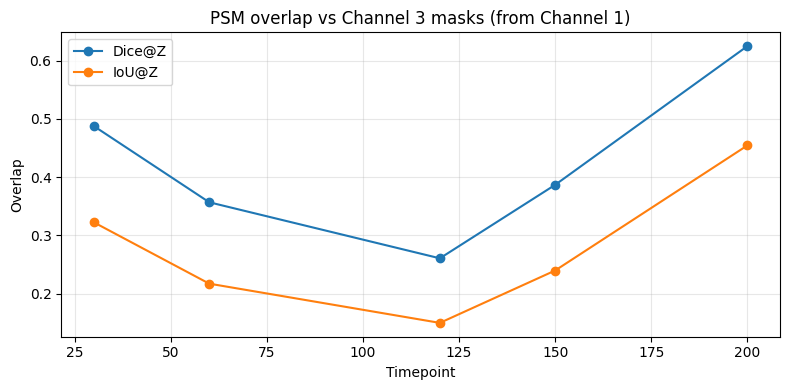

Saved overlap plot: psm_from_ch1/plot_overlap.png


In [8]:
# %% CELL 7: SUMMARY

if RESULTS_PATH.exists():
    df = pd.read_csv(RESULTS_PATH).sort_values("timepoint")
    display(df)

    print("\nSummary on evaluated frames (slice-based):")
    print(df[["dice_z", "iou_z", "elapsed_s"]].describe())

    # Simple plot
    plt.figure(figsize=(8, 4))
    plt.plot(df["timepoint"], df["dice_z"], marker="o", label="Dice@Z")
    plt.plot(df["timepoint"], df["iou_z"], marker="o", label="IoU@Z")
    plt.xlabel("Timepoint")
    plt.ylabel("Overlap")
    plt.title(f"PSM overlap vs Channel 3 masks (from Channel {RAW_CHANNEL})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    out_plot = OUTPUT_DIR / "plot_overlap.png"
    plt.savefig(out_plot, dpi=150, bbox_inches="tight")
    plt.show()

    print(f"Saved overlap plot: {out_plot}")
else:
    print("No results.csv found yet. Run Cell 6 first.")

